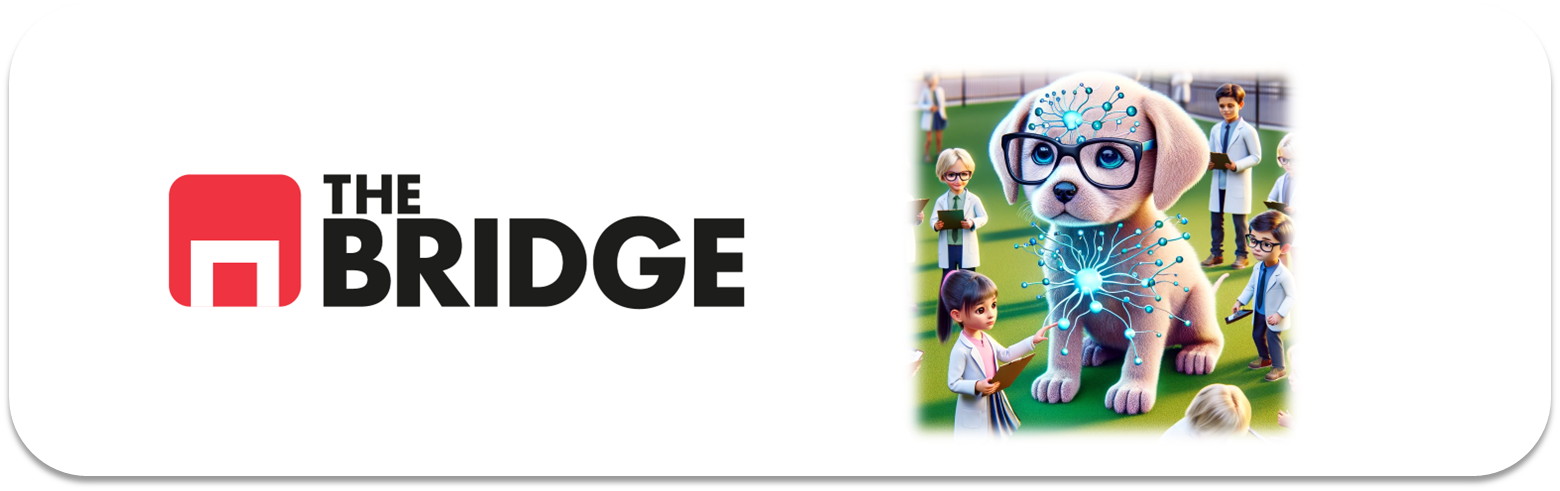

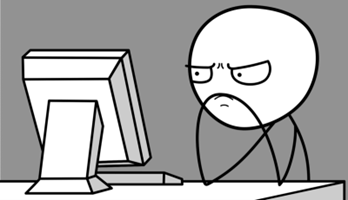

Para ejercitarte y afianzar lo aprendido sobre **Redes Recurrentes y series temporales**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [96]:
import numpy as np
import pandas as pd
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from pmdarima.arima import ARIMA, auto_arima
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from packaging import version
assert version.parse(tf.__version__) >= version.parse("2.8.0")

### Problema a resolver

El ayuntamiento de New City está preocupado por el nivel de contaminación de aire y quiere poner en marcha un sistema de prevención del uso de determinado tipo de vehículos y maquinaria pesada en aquellos días en los que la contaminación sea muy alta, en concreto queremos anticiparnos en periodos de 6 horas. Como primer paso para la implantación de la medida, decide crear un modelo de predicción de contaminación de forma que pueda emplearlo para enviar alertas o avisos de posible de prohibición con la suficiente anticipación que permita a los ciudadanos y trabajadores organizarse mejor. 

Para ello nos ha suministrado una serie de datos de contaminación del aire en cinco años dependiente de una serie de features que son medibles día a día y nos pide crear dicho modelo. Como somos unos "pioneros" vamos a hacerlo empleando lo aprendido con redes recurrentes.

A través de los siguientes ejercicios vamos a crear un modelo de regresión que permita estimar dicha polución en los periodos estimados. Aquí tienes un breve descripción de las columnas:

- **No**: número de fila
- **year**: año de los datos en esta fila
- **month**: mes de los datos en esta fila
- **day**: día de los datos en esta fila
- **hour**: hora de los datos en esta fila
- **pm2.5**: concentración de PM2.5
- **DEWP**: Punto de rocío
- **TEMP**: Temperatura
- **PRES**: Presión
- **cbwd**: Dirección combinada del viento
- **Iws**: Velocidad acumulada del viento
- **Is**: Horas acumuladas de nieve
- **Ir**: Horas acumuladas de lluvia


### Ejercicio 1: Visión preliminar

Carga el dataset. Echa un vistazo (no pintes series todavía) y decide cuál debe ser el target.

In [97]:
df = pd.read_csv("./data/air_pollution_new_city.csv", sep = "|")
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,25,2019,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,26,2019,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,27,2019,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,28,2019,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,29,2019,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,43820,2023,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43796,43821,2023,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43797,43822,2023,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43798,43823,2023,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [98]:
target = "pm2.5"

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43800 non-null  int64  
 1   year    43800 non-null  int64  
 2   month   43800 non-null  int64  
 3   day     43800 non-null  int64  
 4   hour    43800 non-null  int64  
 5   pm2.5   43800 non-null  float64
 6   DEWP    43800 non-null  int64  
 7   TEMP    43800 non-null  float64
 8   PRES    43800 non-null  float64
 9   cbwd    43800 non-null  object 
 10  Iws     43800 non-null  float64
 11  Is      43800 non-null  int64  
 12  Ir      43800 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


### Ejercicio 2: Preparación del dataset

Como todo dataset con series temporales, si tenemos las fechas, es conveniente convertirla a datatime y luego hacerlo el indice de nuestro dataset. Hazlo sobre un dataframe df_indexed copia del original. Deshazte de las columnas que no sean informativas y cambia el nombre de las columnas para que sean más "expresivas".

In [100]:
df_indexed = df.copy()
df_indexed["fecha"] = pd.to_datetime(df_indexed[["year", "month", "day", "hour"]])
df_indexed = df_indexed.sort_values("fecha").set_index("fecha")
df_indexed.drop(columns = ["No", "year", "month", "day", "hour"], inplace = True)
df_indexed.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
fecha,,,,,,,,
2019-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2019-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2019-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2019-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2019-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [101]:
new_columns = ["conc_pm", "punto_rocio", "temperatura", "presion", "direccion_viento", "velocidad_viento", "horas_nieve", "horas_lluvia"]
target = "conc_pm"
df_indexed.columns = new_columns
df_indexed.head()

,conc_pm,punto_rocio,temperatura,presion,direccion_viento,velocidad_viento,horas_nieve,horas_lluvia
fecha,,,,,,,,
2019-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2019-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2019-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2019-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2019-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


### Ejercicio 3: Split y MiniEda_I

Antes de continuar es hora analizar visualmente las series, pero para hacerlo formalmente correcto, analiza sólo de 2019 a 2022 (2023 será nuestro periodo de validaciones y test). Crea una gráfica com el target para el periodo de train. Descompón la serie de forma aditiva y analiza visualmente si existe estacionalidad, tendencia y si podríamos decir si es estacionaria o no

In [102]:
train = df_indexed["2019":"2022"].copy()
val_test = df_indexed["2023":].copy()

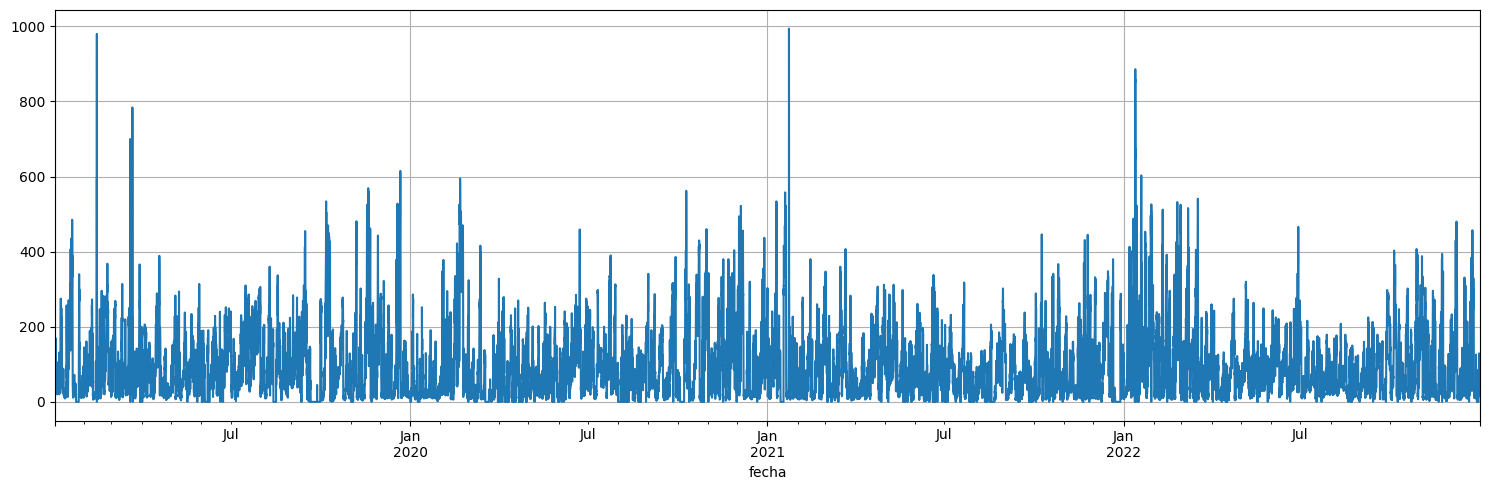

In [103]:
train[target].plot(grid = True, figsize = (15, 5) ) # Al hacer la fecha el indice podemos utilizarla facilmente como índice
plt.tight_layout()

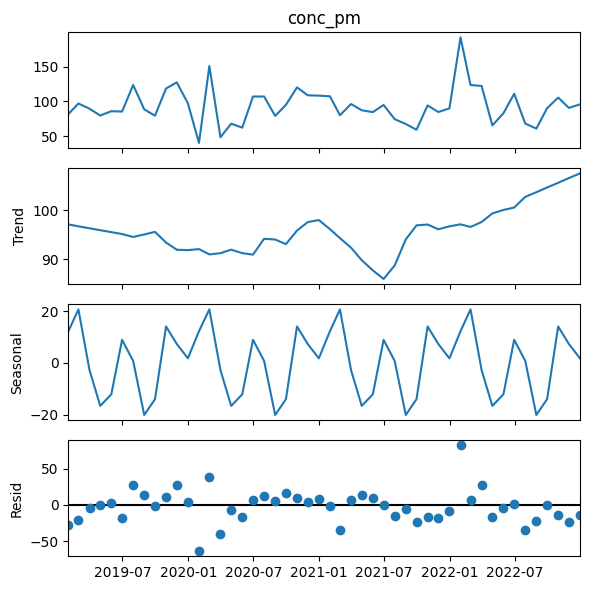

In [104]:
train_mensualizado = train.resample("M").mean(numeric_only = True)
result_add = seasonal_decompose(train_mensualizado[target], model = 'additive', extrapolate_trend = 'freq')

# Plot
plt.rcParams.update({'figure.figsize': (6,6)})
result_add.plot();

### Ejercicio 4: MiniEDA (II)

Para completar el minieda, crea una figura con tantos subplots como series temporales y en cada subplot muestra una de las series para el train. Empieza por el target y haz un pequeño análisis visual. Por supuesto, emplea sólo el train

TypeError: no numeric data to plot

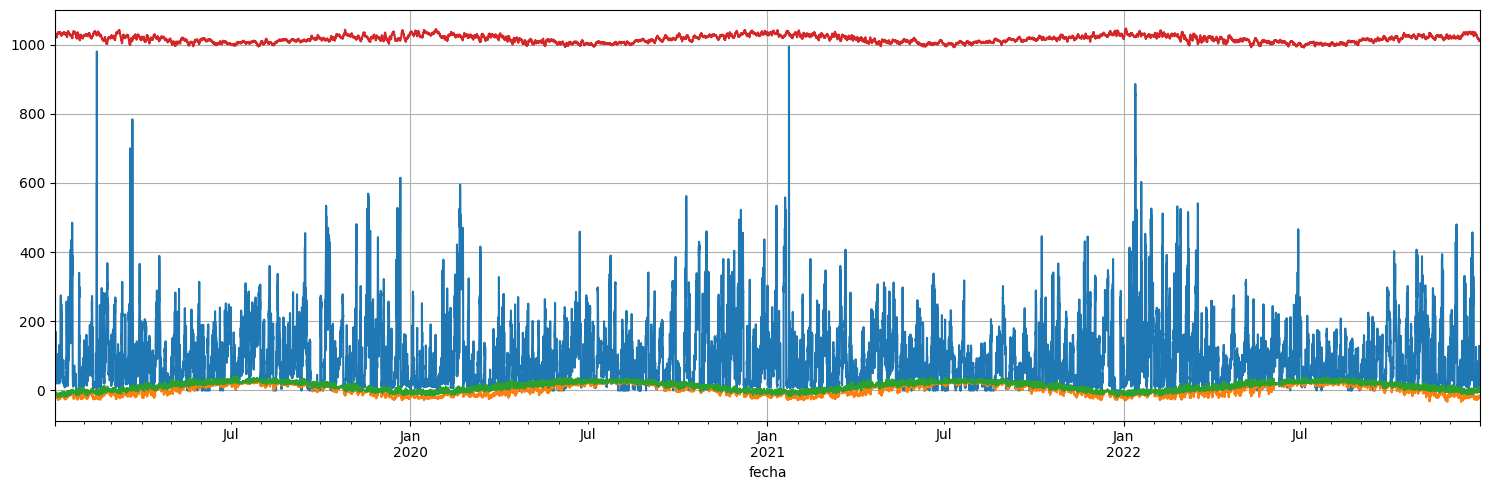

In [105]:
for col in train.columns:
    train[col].plot(grid = True, figsize = (15, 5))
    plt.tight_layout()

### Ejercicio 5

Vamos a preparar el dataset. En principio vamos a predecir el valor de las siguientes 12 horas a partir de las 48 horas anteriores. Es decir hay que ajustar el dataset para que genere batches de 32 secuencias de 48 instancias y con un target que es una secuencia de los 12 periodos siguientes. Primero codifica la dirección del viento con un one-hot encoding sobre el df_indexed. Convierte todos los valores a np.float32 al final: 

In [106]:
train = pd.get_dummies(train, columns = ["direccion_viento"], dtype = np.float32)
train.head()

,conc_pm,punto_rocio,temperatura,presion,velocidad_viento,horas_nieve,horas_lluvia,direccion_viento_NE,direccion_viento_NW,direccion_viento_SE,direccion_viento_cv
fecha,,,,,,,,,,,
2019-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0.0,0.0,1.0,0.0
2019-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0.0,0.0,1.0,0.0
2019-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0.0,0.0,1.0,0.0
2019-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0.0,0.0,1.0,0.0
2019-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0.0,0.0,1.0,0.0


In [107]:
escalado_target = train[target].max()

In [108]:
train[target] = train[target] / escalado_target

In [109]:
from sklearn.preprocessing import MinMaxScaler

num_scaler = MinMaxScaler()
train = num_scaler.fit_transform(train)

In [110]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq_length = 48

def split_inputs_and_targets(df, ahead = 12, target_col = 0):
    return df[:, :-ahead], df[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    train,
    targets = None,
    sequence_length = seq_length + 12, # Alargamos las secuencias
    batch_size = 32,
    shuffle = True,
    seed = 42
).map(split_inputs_and_targets)

In [111]:
list(ahead_train_ds)[0]

(<tf.Tensor: shape=(32, 48, 11), dtype=float64, numpy=
 array([[[0.12072435, 0.31147541, 0.2       , ..., 0.        ,
          1.        , 0.        ],
         [0.12676056, 0.29508197, 0.21666667, ..., 0.        ,
          1.        , 0.        ],
         [0.15694165, 0.29508197, 0.18333333, ..., 0.        ,
          0.        , 1.        ],
         ...,
         [0.        , 0.18032787, 0.23333333, ..., 1.        ,
          0.        , 0.        ],
         [0.        , 0.18032787, 0.21666667, ..., 1.        ,
          0.        , 0.        ],
         [0.        , 0.18032787, 0.21666667, ..., 1.        ,
          0.        , 0.        ]],
 
        [[0.02515091, 0.75409836, 0.56666667, ..., 1.        ,
          0.        , 0.        ],
         [0.02615694, 0.75409836, 0.56666667, ..., 0.        ,
          0.        , 1.        ],
         [0.02414487, 0.73770492, 0.58333333, ..., 0.        ,
          0.        , 1.        ],
         ...,
         [0.02816901, 0.54098361

### Ejercicio 6

Ahora crea los datasets de train, validación y test. El primero para que tenga el periodo 2020 septiembre de 2023, el segundo para octubre de 2023 y el tercero para noviembre de 2023. Ojo ten en cuenta que vamos a necesitar tanto los valores anteriores como posteriores en los periodos (48 horas antes y 12 horas después). Escálalos (importante, escala el target por separado para poder hacer la inversión en el momento de evaluar)

In [112]:
val = val_test[:"2023-10"]
test = val_test["2023-10":]

val = pd.get_dummies(val, columns = ["direccion_viento"], dtype = np.float32)
test = pd.get_dummies(test, columns = ["direccion_viento"], dtype = np.float32)

In [113]:
val[target] = val[target] / escalado_target
val = num_scaler.transform(val)

In [114]:
test[target] = test[target] / escalado_target
test = num_scaler.transform(test)

In [115]:
ahead_val_ds = tf.keras.utils.timeseries_dataset_from_array(
    val,
    targets = None,
    sequence_length = seq_length + 12, # Alargamos las secuencias
    batch_size = 32,
    shuffle = False,
    seed = 42
).map(split_inputs_and_targets)

In [116]:
ahead_test_ds = tf.keras.utils.timeseries_dataset_from_array(
    test,
    targets = None,
    sequence_length = seq_length + 12, # Alargamos las secuencias
    batch_size = 32,
    shuffle = False,
    seed = 42
).map(split_inputs_and_targets)

### Ejercicio 8

Crea un modelo con una capa de celdas sencillas recurrentes con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

In [ ]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs = 500, patience = None):
    patience = int(epochs//10) if patience == None else patience # Si no nos dan "paciencia" el 10% de las épocas
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor = "val_mae", patience = patience, restore_best_weights = True)
    opt = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9)
    model.compile(loss = tf.keras.losses.Huber(), optimizer = opt, metrics = ["mae"])
    history = model.fit(train_set, validation_data = valid_set, epochs = epochs,
                        callbacks = [early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * escalado_target

In [118]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape = [None, 11]),
    tf.keras.layers.Dense(12)
])

In [119]:
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_val_ds, learning_rate = 0.02)

Epoch 1/500
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0130 - mae: 0.1062 - val_loss: 0.0038 - val_mae: 0.0624
Epoch 2/500
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0034 - mae: 0.0592 - val_loss: 0.0031 - val_mae: 0.0534
Epoch 3/500
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0028 - mae: 0.0537 - val_loss: 0.0024 - val_mae: 0.0491
Epoch 4/500
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0024 - mae: 0.0493 - val_loss: 0.0021 - val_mae: 0.0444
Epoch 5/500
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0022 - mae: 0.0465 - val_loss: 0.0020 - val_mae: 0.0434
Epoch 6/500
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0021 - mae: 0.0447 - val_loss: 0.0018 - val_mae: 0.0405
Epoch 7/500
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0021 - mae: 0.0439 - val_loss: 0.0017 - val_mae: 0.0396
Epoch 8/500
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0020 - mae: 0.0427 - val_loss: 0.0017 - val_mae: 0.0392
Epoch 9/500
1094/1094 ━━━━━━━━━

34.91244151443243

In [120]:
X = test[np.newaxis, :seq_length]
y_test = test[seq_length:seq_length + 12, 0]

y_pred = ahead_model.predict(X)  # shape [1, 14]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


In [121]:
y_test_real = y_test * escalado_target
y_pred_real = y_pred[0] * escalado_target

print("RMSE:", np.sqrt(mean_squared_error(y_test_real, y_pred_real)))
print("MAPE:", mean_absolute_percentage_error(y_test_real, y_pred_real) * 100)

RMSE: 48.630146057502614
MAPE: 59.93840638685772


### Ejercicio 9

Crea un modelo con una capa de celdas LSTM con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

In [122]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, input_shape = [None, 11]),
    tf.keras.layers.Dense(12)
])

In [123]:
fit_and_evaluate(lstm_model, ahead_train_ds, ahead_val_ds, learning_rate = 0.01, patience = 25)

Epoch 1/500
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.0067 - mae: 0.0847 - val_loss: 0.0038 - val_mae: 0.0612
Epoch 2/500
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0035 - mae: 0.0602 - val_loss: 0.0031 - val_mae: 0.0551
Epoch 3/500
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0030 - mae: 0.0554 - val_loss: 0.0026 - val_mae: 0.0503
Epoch 4/500
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0027 - mae: 0.0522 - val_loss: 0.0023 - val_mae: 0.0470
Epoch 5/500
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0025 - mae: 0.0500 - val_loss: 0.0021 - val_mae: 0.0450
Epoch 6/500
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0024 - mae: 0.0485 - val_loss: 0.0020 - val_mae: 0.0435
Epoch 7/500
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0023 - mae: 0.0475 - val_loss: 0.0019 - val_mae: 0.0426
Epoch 8/500
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0022 - mae: 0.0467 - val_loss: 0.0019 - val_mae: 0.0419
Epoch 9/500
1094

34.087219439446926

In [124]:
y_pred = lstm_model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


In [125]:
y_pred_real = y_pred[0] * escalado_target

print("RMSE:", np.sqrt(mean_squared_error(y_test_real, y_pred_real)))
print("MAPE:", mean_absolute_percentage_error(y_test_real, y_pred_real) * 100)

RMSE: 31.408871625732594
MAPE: 36.404126891139725


### Ejercicio 10

Crea un modelo con una capa de celdas GRU con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

In [126]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, input_shape = [None, 11]),
    tf.keras.layers.Dense(12)
])

In [127]:
fit_and_evaluate(gru_model, ahead_train_ds, ahead_val_ds, learning_rate = 0.1, epochs = 500, patience = 25)

Epoch 1/500
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 0.0047 - mae: 0.0677 - val_loss: 0.0018 - val_mae: 0.0404
Epoch 2/500
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0020 - mae: 0.0426 - val_loss: 0.0016 - val_mae: 0.0374
Epoch 3/500
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0019 - mae: 0.0407 - val_loss: 0.0016 - val_mae: 0.0372
Epoch 4/500
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0019 - mae: 0.0403 - val_loss: 0.0015 - val_mae: 0.0363
Epoch 5/500
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0019 - mae: 0.0399 - val_loss: 0.0015 - val_mae: 0.0365
Epoch 6/500
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0018 - mae: 0.0395 - val_loss: 0.0015 - val_mae: 0.0368
Epoch 7/500
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0018 - mae: 0.0395 - val_loss: 0.0015 - val_mae: 0.0360
Epoch 8/500
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0018 - mae: 0.0393 - val_loss: 0.0015 - val_mae: 0.0367
Epoch 9/500
1094

32.76454459875822

In [128]:
y_pred = gru_model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


In [129]:
y_pred_real = y_pred[0] * escalado_target

print("RMSE:", np.sqrt(mean_squared_error(y_test_real, y_pred_real)))
print("MAPE:", mean_absolute_percentage_error(y_test_real, y_pred_real) * 100)

RMSE: 34.69918289015176
MAPE: 41.3196843034749
